In [6]:
!pip install scanpy scipy umap-learn leidenalg
!pip install hmmlearn
!pip install scikit-learn --quiet

Set up

In [7]:
import scanpy as sc
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import scipy.sparse
from sklearn.mixture import GaussianMixture
from sklearn.metrics import precision_recall_fscore_support
from hmmlearn import hmm
from scipy import stats
from scipy.ndimage import uniform_filter1d
from scipy.ndimage import gaussian_filter1d
from scipy import stats
from scipy.signal import medfilt, savgol_filter
import re
import itertools

Fetch the data and intergrate into one

In [8]:
adata_day0 = sc.read_10x_h5("/content/GSM3814885_day0_filtered_gene_bc_matrices_h5.h5")
adata_day4 = sc.read_10x_h5("/content/GSM3814886_day4_filtered_gene_bc_matrices_h5.h5")
adata_day6 = sc.read_10x_h5("/content/GSM3814887_day6_filtered_gene_bc_matrices_h5.h5")
adata_day8 = sc.read_10x_h5("/content/GSM3814888_day8_rep1_filtered_gene_bc_matrices_h5.h5")
adata_day12 = sc.read_10x_h5("/content/GSM3814891_day12_filtered_gene_bc_matrices_h5.h5")

/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_name

In [9]:
adata_day0.obs["sample"] = "day0"
adata_day4.obs["sample"] = "day4"
adata_day6.obs["sample"] = "day6"
adata_day8.obs["sample"] = "day8"
adata_day12.obs["sample"] = "day12"

In [10]:
adata_day0.var_names_make_unique()
adata_day4.var_names_make_unique()
adata_day6.var_names_make_unique()
adata_day8.var_names_make_unique()
adata_day12.var_names_make_unique()

In [11]:
adata = ad.concat(
    [adata_day0, adata_day4, adata_day6, adata_day8, adata_day12],
    join="outer",  # keep all genes
    label="batch", # new column adata.obs["batch"]
    keys=["day0", "day4", "day6", "day8", "day12"],
    fill_value=0
)

/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [12]:
print(adata)
adata.obs["sample"].value_counts()

AnnData object with n_obs × n_vars = 27861 × 33694
    obs: 'sample', 'batch'


,count
sample,
day0,8179
day12,6492
day8,5285
day6,4127
day4,3778


In [13]:
# normalization + log1p
if adata.X.max() > 100:
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

# PCA
sc.pp.pca(adata)

# build neigbors
sc.pp.neighbors(adata)

# visualization（UMAP）
sc.tl.umap(adata)

# Leiden cluster
sc.tl.leiden(adata, key_added='leiden_clusters')

<ipython-input-13-38c6bb361444>:16: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, key_added='leiden_clusters')


Functions

In [14]:
def find_cluster_references(
    adata: sc.AnnData,
    cluster_key: str = 'leiden_clusters',
    layer: str | None = None,
    n_genes_subset: int = 3000,
    gmm_components: int = 2,
    random_state: int = 42,
    verbose: bool = False
) -> dict[str, list[str]]:
    """
    For each cluster in adata.obs[cluster_key], select a diploid reference
    via low‐variance cells. Returns { cluster: [cell, ...], ... }.
    """
    if cluster_key not in adata.obs:
        raise KeyError(f"{cluster_key!r} not in adata.obs")

    X = adata.layers[layer] if layer else adata.X
    if scipy.sparse.issparse(X):
        X = X.tocsr()

    nonmt = ~adata.var_names.str.upper().str.startswith('MT-')
    avail = np.where(nonmt)[0]
    if len(avail) >= n_genes_subset:
        rng = np.random.RandomState(random_state)
        subset_idx = rng.choice(avail, n_genes_subset, replace=False)
    else:
        subset_idx = avail if len(avail)>0 else np.arange(adata.n_vars)

    refs: dict[str, list[str]] = {}

    clusters = [str(x) for x in adata.obs[cluster_key].unique()]

    for cl in clusters:
        mask_cl = (adata.obs[cluster_key].astype(str).values == cl)
        idx_cl  = np.where(mask_cl)[0]
        if len(idx_cl) < 5:
            if verbose:
                print(f"Cluster {cl!r}: only {len(idx_cl)} cells → skipping")
            refs[cl] = []
            continue

        block = X[idx_cl[:, None], subset_idx]

        if scipy.sparse.issparse(block):
            block = block.toarray()

        vars_ = np.nanvar(block, axis=1, ddof=1).reshape(-1,1)

        gmm = GaussianMixture(n_components=gmm_components,
                              random_state=random_state)
        gmm.fit(vars_)
        lbl = gmm.predict(vars_)
        means = gmm.means_.flatten()
        dip = int(np.argmin(means))

        dip_idx   = idx_cl[lbl == dip]
        dip_cells = adata.obs_names[dip_idx].tolist()
        refs[cl]   = dip_cells

        if verbose:
            print(f"Cluster {cl!r}: {len(dip_cells)}/{len(idx_cl)} refs "
                  f"  (GMM means var={means.round(4)})")

    return refs

In [15]:
def detect_cnas_per_cluster(
    adata,
    cluster_key: str,
    cluster_refs: dict[str, list[str]],
    window_size: int = 100,
    min_genes_per_window: int = 10,
    smoothing_sigma: float = 1.0,
    lfc_threshold: float = 0.1,
    fraction_threshold: float = 0.2,
    layer: str | None = None
) -> tuple[pd.DataFrame, list[dict], pd.DataFrame]:
    """
    For each cluster in adata.obs[cluster_key], uses cluster_refs to compute
    smoothed per-window log2 fold-change and calls gains/losses by requiring
    that at least `fraction_threshold` of windows on a chromosome exceed
    +lfc_threshold (gain) or -lfc_threshold (loss).

    Returns
    -------
    calls_chr : pd.DataFrame
        DataFrame of shape (n_cells, n_chromosomes) with values in {-1, 0, +1}.
    """
    X = adata.layers[layer] if layer else adata.X
    if scipy.sparse.issparse(X):
        X = X.toarray()

    var = adata.var.copy()
    var['chrom'] = var['chromosome'].astype(str)
    var['start'] = pd.to_numeric(var['start'], errors='coerce')
    var = var.dropna(subset=['chrom','start'])
    def chr_key(c):
        c = str(c)
        return (int(c), '') if c.isdigit() else (np.inf, c)
    var['_idx'] = np.arange(var.shape[0])
    var = var.sort_values(['chrom','start'], key=lambda col: col.map(chr_key))
    sorted_idx = var['_idx'].values.astype(int)
    gene_chroms = var['chrom'].values

    Xs = X[:, sorted_idx]
    n_cells, n_win = Xs.shape

    windows = []
    window_expr = []
    for chrom in pd.unique(gene_chroms):
        idx_chr = np.where(gene_chroms == chrom)[0]
        step = max(1, window_size // 2)
        for i in range(0, len(idx_chr), step):
            block = idx_chr[i:i+window_size]
            if len(block) < min_genes_per_window:
                continue
            windows.append({'chrom': chrom, 'genes': block})
            window_expr.append(Xs[:, block].mean(axis=1))
    W = np.stack(window_expr, axis=1)

    chroms = sorted({w['chrom'] for w in windows}, key=chr_key)
    calls_chr = pd.DataFrame(0, index=adata.obs_names, columns=chroms, dtype=int)

    for cl in adata.obs[cluster_key].astype(str).unique():
        refs = cluster_refs.get(cl, [])
        if len(refs) < min_genes_per_window:
            continue
        mask_cl = (adata.obs[cluster_key].astype(str) == cl).values
        idx_cl = np.where(mask_cl)[0]
        mask_ref = adata.obs_names.isin(refs)
        idx_ref = np.where(mask_ref)[0]
        if len(idx_ref) == 0:
            continue
        ref_med = np.median(W[idx_ref, :], axis=0)
        ref_med = np.clip(ref_med, 1e-6, None)
        L = np.log2((W[idx_cl, :] + 1e-6) / ref_med[np.newaxis, :])
        if smoothing_sigma > 0:
            for chrom in chroms:
                win_idxs = [i for i,w in enumerate(windows) if w['chrom']==chrom]
                if len(win_idxs) > 1:
                    L[:, win_idxs] = gaussian_filter1d(
                        L[:, win_idxs],
                        sigma=smoothing_sigma,
                        axis=1,
                        mode='reflect'
                    )
        for chrom in chroms:
            win_idxs = [i for i,w in enumerate(windows) if w['chrom']==chrom]
            sub = L[:, win_idxs]
            frac_gain = (sub > lfc_threshold).sum(axis=1) / len(win_idxs)
            frac_loss = (sub < -lfc_threshold).sum(axis=1) / len(win_idxs)
            cells = adata.obs_names[idx_cl]
            calls_chr.loc[cells[frac_gain >= fraction_threshold], chrom] = +1
            calls_chr.loc[cells[frac_loss >= fraction_threshold], chrom] = -1

    return calls_chr, windows, var

In [16]:
def extract_cna_segments_fast(
    calls_chr: pd.DataFrame,
    windows: list[dict],
    var: pd.DataFrame
) -> pd.DataFrame:
    """
    Vectorized version of extract_cna_segments (faster).
    """
    segment_list = []

    for w in windows:
        chrom = w['chrom']
        gene_inds = w['genes']
        gene_names = var.index[gene_inds]

        start = var.loc[gene_names, 'start'].min()
        end   = var.loc[gene_names, 'end'].max()

        if chrom not in calls_chr.columns:
            continue

        subset = calls_chr[chrom]
        mask = subset != 0

        seg = pd.DataFrame({
            'cell': subset.index[mask],
            'chromosome': chrom,
            'start': start,
            'end': end,
            'genotype': subset[mask].map({1: 'gain', -1: 'loss'})
        })

        segment_list.append(seg)

    return pd.concat(segment_list, ignore_index=True)


In [17]:
cluster_refs = find_cluster_references(
    adata,
    cluster_key='leiden_clusters',
    n_genes_subset=3000,
    gmm_components=2,
    random_state=42,
    verbose=True
)


Cluster '0': 1609/2662 refs   (GMM means var=[0.1114 0.1166])
Cluster '2': 1357/2289 refs   (GMM means var=[0.1172 0.1215])
Cluster '15': 467/664 refs   (GMM means var=[0.1231 0.1175])
Cluster '17': 339/415 refs   (GMM means var=[0.1201 0.1279])
Cluster '18': 69/183 refs   (GMM means var=[0.134  0.1175])
Cluster '4': 1503/2135 refs   (GMM means var=[0.12  0.113])
Cluster '13': 880/961 refs   (GMM means var=[0.1217 0.1259])
Cluster '3': 1694/2235 refs   (GMM means var=[0.1275 0.1241])
Cluster '16': 206/425 refs   (GMM means var=[0.1305 0.1244])
Cluster '19': 14/17 refs   (GMM means var=[0.1231 0.137 ])
Cluster '6': 1459/1996 refs   (GMM means var=[0.1248 0.1177])
Cluster '5': 1714/2114 refs   (GMM means var=[0.118  0.1239])
Cluster '7': 1051/1796 refs   (GMM means var=[0.1247 0.1326])
Cluster '14': 570/702 refs   (GMM means var=[0.1208 0.117 ])
Cluster '9': 1330/1666 refs   (GMM means var=[0.125  0.1207])
Cluster '12': 593/1108 refs   (GMM means var=[0.123  0.1309])
Cluster '10': 1058/1

Data annotation

In [ ]:
!pip install mygene

from mygene import MyGeneInfo
import pandas as pd

In [19]:
mg = MyGeneInfo()

# get all gene names（default adata.var_names）
genes = adata.var_names.tolist()

# search for chromosome
query = mg.querymany(genes, scopes='symbol', fields='chromosome', species='human')


INFO:biothings.client:querying 1-1000 ...
INFO:biothings.client:querying 1001-2000 ...
INFO:biothings.client:querying 2001-3000 ...
INFO:biothings.client:querying 3001-4000 ...
INFO:biothings.client:querying 4001-5000 ...
INFO:biothings.client:querying 5001-6000 ...
INFO:biothings.client:querying 6001-7000 ...
INFO:biothings.client:querying 7001-8000 ...
INFO:biothings.client:querying 8001-9000 ...
INFO:biothings.client:querying 9001-10000 ...
INFO:biothings.client:querying 10001-11000 ...
INFO:biothings.client:querying 11001-12000 ...
INFO:biothings.client:querying 12001-13000 ...
INFO:biothings.client:querying 13001-14000 ...
INFO:biothings.client:querying 14001-15000 ...
INFO:biothings.client:querying 15001-16000 ...
INFO:biothings.client:querying 16001-17000 ...
INFO:biothings.client:querying 17001-18000 ...
INFO:biothings.client:querying 18001-19000 ...
INFO:biothings.client:querying 19001-20000 ...
INFO:biothings.client:querying 20001-21000 ...
INFO:biothings.client:querying 2100

In [20]:
from mygene import MyGeneInfo
mg = MyGeneInfo()

# insert adata.var_names as query
query = mg.querymany(
    adata.var_names.tolist(),
    scopes='symbol',
    fields='symbol,name,chromosome,genomic_pos',
    species='human'
)

# transform DataFrame and set index
df = pd.DataFrame(query).set_index('query')

# print out and check 'chromosome'、'genomic_pos'
print(df.columns)
print(df.head())

INFO:biothings.client:querying 1-1000 ...
INFO:biothings.client:querying 1001-2000 ...
INFO:biothings.client:querying 2001-3000 ...
INFO:biothings.client:querying 3001-4000 ...
INFO:biothings.client:querying 4001-5000 ...
INFO:biothings.client:querying 5001-6000 ...
INFO:biothings.client:querying 6001-7000 ...
INFO:biothings.client:querying 7001-8000 ...
INFO:biothings.client:querying 8001-9000 ...
INFO:biothings.client:querying 9001-10000 ...
INFO:biothings.client:querying 10001-11000 ...
INFO:biothings.client:querying 11001-12000 ...
INFO:biothings.client:querying 12001-13000 ...
INFO:biothings.client:querying 13001-14000 ...
INFO:biothings.client:querying 14001-15000 ...
INFO:biothings.client:querying 15001-16000 ...
INFO:biothings.client:querying 16001-17000 ...
INFO:biothings.client:querying 17001-18000 ...
INFO:biothings.client:querying 18001-19000 ...
INFO:biothings.client:querying 19001-20000 ...
INFO:biothings.client:querying 20001-21000 ...
INFO:biothings.client:querying 2100

Index(['notfound', '_id', '_score', 'genomic_pos', 'name', 'symbol'], dtype='object')
             notfound     _id     _score  \
query                                      
RP11-34P13.3     True     NaN        NaN   
FAM138A           NaN  645520  27.428700   
OR4F5             NaN   79501  25.715385   
RP11-34P13.7     True     NaN        NaN   
RP11-34P13.8     True     NaN        NaN   

                                                    genomic_pos  \
query                                                             
RP11-34P13.3                                                NaN   
FAM138A       {'chr': '1', 'end': 37595, 'ensemblgene': 'ENS...   
OR4F5         {'chr': '1', 'end': 71585, 'ensemblgene': 'ENS...   
RP11-34P13.7                                                NaN   
RP11-34P13.8                                                NaN   

                                                          name   symbol  
query                                                        

In [21]:
# process genomic_pos
def unpack_genomic_pos(row):
    pos = row.get('genomic_pos')
    if isinstance(pos, dict):
        return pd.Series({
            'chromosome': pos.get('chr'),
            'start': pos.get('start'),
            'end': pos.get('end')
        })
    else:
        return pd.Series({'chromosome': None, 'start': None, 'end': None})

# apply to dataframe
df_pos = df.apply(unpack_genomic_pos, axis=1)

# avoid duplicate index
df_pos_dedup = df_pos.loc[~df_pos.index.duplicated(keep='first')]

# align index
adata.var['chromosome'] = df_pos_dedup['chromosome'].reindex(adata.var_names)
adata.var['start'] = df_pos_dedup['start'].reindex(adata.var_names)
adata.var['end'] = df_pos_dedup['end'].reindex(adata.var_names)

Run detect CNA per cluster function

In [22]:
calls_chr, windows, var_sorted = detect_cnas_per_cluster(
    adata,
    cluster_key='leiden_clusters',
    cluster_refs=cluster_refs,
    window_size=100,
    min_genes_per_window=10,
    smoothing_sigma=1.0,
    lfc_threshold=0.05,
    fraction_threshold=0.2,
    layer=None
)

Run extract CNA segment function

In [23]:
segments_df = extract_cna_segments_fast(
    calls_chr=calls_chr,
    windows=windows,
    var=adata.var
)


In [26]:
cna_segments = extract_cna_segments_fast(calls_chr, windows, var_sorted)

In [27]:
cna_segments = (
    cna_segments
    .merge(
        adata.obs[['leiden_clusters']],
        left_on='cell',
        right_index=True
    )
)
cna_segments.head()

,cell,chromosome,start,end,genotype,leiden_clusters
0,AAACCTGAGAATTGTG-1,1,1001138.0,111478512.0,loss,0
1,AAACCTGAGACAATAC-1,1,1001138.0,111478512.0,loss,2
2,AAACCTGAGACTACAA-1,1,1001138.0,111478512.0,loss,15
3,AAACCTGAGACTTTCG-1,1,1001138.0,111478512.0,gain,0
4,AAACCTGAGGCGTACA-1,1,1001138.0,111478512.0,loss,0


Summarize CNAs on each chromosome

In [50]:
import pandas as pd

def summarize_chr_cna(segments_df: pd.DataFrame) -> pd.DataFrame:
    summary = (
        segments_df.groupby(['chromosome', 'genotype'])
        .size()
        .unstack(fill_value=0)
        .rename_axis(None, axis=1)
        .reset_index()
    )

    # make up all the columns
    if 'gain' not in summary.columns:
        summary['gain'] = 0
    if 'loss' not in summary.columns:
        summary['loss'] = 0

    return summary.sort_values('chromosome')

In [51]:
summary_df = summarize_chr_cna(segments_df)
display(summary_df)

,chromosome,gain,loss
0,1,211812,846716
1,10,117216,327776
2,11,125112,543288
3,12,128440,400577
4,13,49450,229060
5,14,80820,336885
6,15,73678,232012
7,16,83145,334500
8,17,82940,474280
9,18,56760,108156


Visualization

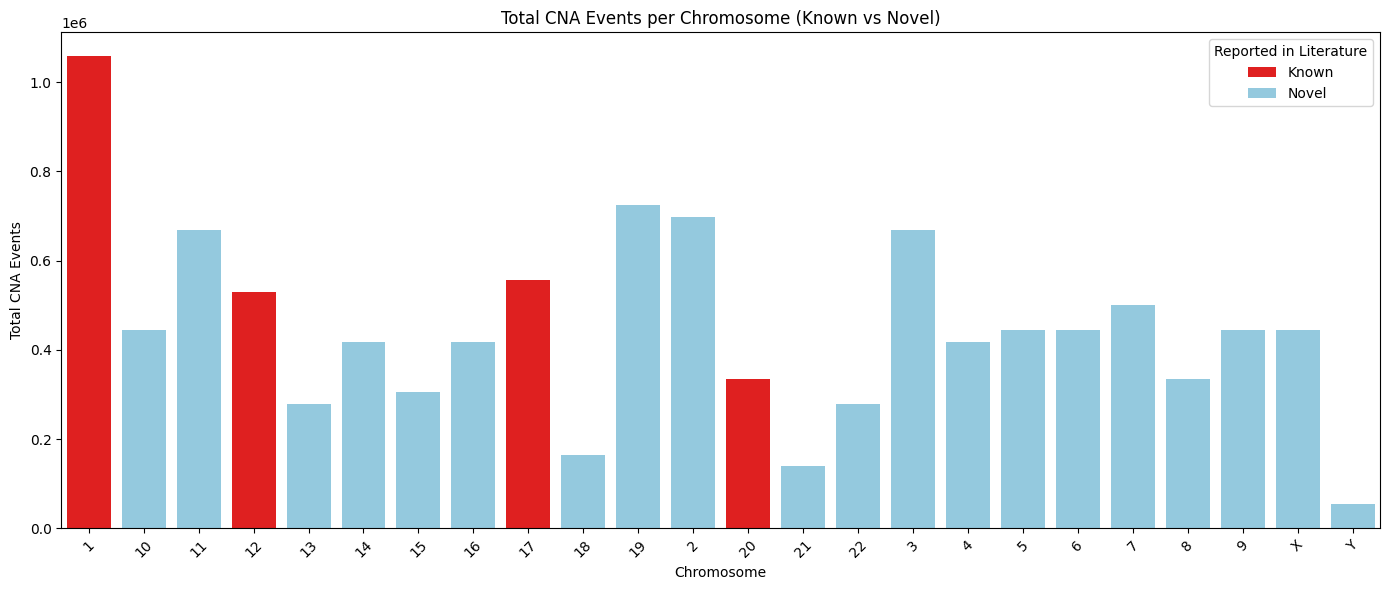

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# data we inferred
data = pd.DataFrame({
    "chromosome": [
        "1", "10", "11", "12", "13", "14", "15", "16", "17", "18",
        "19", "2", "20", "21", "22", "3", "4", "5", "6", "7",
        "8", "9", "X", "Y"
    ],
    "gain": [
        211812,117216,125112,128440,49450,80820,73678,83145,82940,56760,
        176046,125000,77616,38345,55960,122928,93990,121312,114480,103608,
        82800,105632,107712,25826
    ],
    "loss": [
        846716,327776,543288,400577,229060,336885,232012,334500,474280,108156,
        547586,571525,255984,100515,222570,545712,323460,322400,330832,397764,
        251064,339664,337632,28086
    ]
})

# 加上 total_cna
data["total_cna"] = data["gain"] + data["loss"]

# Step 1:  annotate known CNA chromosome
#  GSE131736 mentioned chr1、chr12、chr17、chr20 have CNVs
known_cna_chrs = {"1", "12", "17", "20"}
data["status"] = data["chromosome"].apply(lambda x: "Known" if x in known_cna_chrs else "Novel")

# Step 2: visualization
plt.figure(figsize=(14, 6))
sns.barplot(data=data, x="chromosome", y="total_cna", hue="status", dodge=False, palette={"Known": "red", "Novel": "skyblue"})

plt.title("Total CNA Events per Chromosome (Known vs Novel)")
plt.ylabel("Total CNA Events")
plt.xlabel("Chromosome")
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title="Reported in Literature")
plt.show()
